In [4]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Concatenate, TimeDistributed, LSTM, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.autograph.experimental import do_not_convert
from sklearn.model_selection import train_test_split
import numpy as np
from helper_funcs import gen_samples
from scipy.fft import rfftfreq
import pickle
import matplotlib.pyplot as plt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# First navigate to our directory
transfer_directory_path = os.path.join("Data", "synth_transfer_df.parquet")
general_directory_path = os.path.join("Data", "synth_general_df.parquet")
# Load the dataframes
synth_transfer_df = pd.read_parquet(transfer_directory_path)
synth_general_df = pd.read_parquet(general_directory_path)
# Concatenate (after making sure they share columns) and then reset indices
assert list(synth_transfer_df.columns) == list(synth_general_df.columns), "Column names do not match!"
df = pd.concat([synth_transfer_df, synth_general_df], axis=0)
df.reset_index(drop=True, inplace=True)

In [16]:
rs=1
# Split into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['species'],  # Stratify based on the 'species' column
    random_state=rs
)

# Split temp into test (15%) and validation (15%)
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['species'],  # Stratify again to maintain balance
    random_state=rs
)

In [17]:
# Prepare samples
print("Generating Training Samples")
X_train, y_train, mins_maxes_train, isolated_peaks_train = gen_samples(train_df)
print("Generating Test Samples")
X_test, y_test, mins_maxes_test, isolated_peaks_test = gen_samples(test_df)
print("Generating Validation Samples")
X_val, y_val, mins_maxes_val, isolated_peaks_val = gen_samples(val_df)

# Restrict to just peak labels (no height/width)
y_train=y_train[:, :, 0]
y_test=y_test[:, :, 0]
y_val=y_val[:, :, 0]

M=200
y_train=y_train[0:M, :]
y_test=y_test[0:M, :]
y_val=y_val[0:M, :]

X_train=X_train[0:M, :]
X_val=X_val[0:M, :]
X_test=X_test[0:M, :]

# X_train = np.expand_dims(X_train, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

# y_train = np.expand_dims(y_train, axis=-1)
# y_val = np.expand_dims(y_val, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)

# Reshape inputs
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Reshape outputs
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

Generating Training Samples
Generating Test Samples
Generating Validation Samples


In [18]:
print(X_train.dtype, y_train.shape)

float64 (200, 8192, 1)


In [12]:
N = 8192
M = 200
X_train = np.random.rand(M, N, 1)
y_train = np.random.randint(0, 2, size=(M, N, 1))
X_val = np.random.rand(M, N, 1)
y_val = np.random.randint(0, 2, size=(M, N, 1))

In [13]:
# Set model parameters 
k=3
peak_encourage=5
include_LSTM=False
epochs = 1
lr = 0.001
model_version = f"SL_V1_k-{k}_PE-{peak_encourage}_LSTM-{include_LSTM}_Epochs-{epochs}_LR-{lr}"
batch_size = 32
patience = 3
threshold_list = [0.05, 0.1, 0.15, 0.2]

In [14]:
# DEFINE MODEL STRUCTURE
# Define the input length / number of frequency bins (N)
N = 8192

# Input layer
input_layer = Input(shape=(N, 1), name="Input")
# Inception-like layer with 1D convolutions
convs = []
# We'll base our kernel choices on the hwhm distribution of the peaks. 
# Thin peaks are in 3Hz-10Hz range --> 5-15 bins
# Wide peaks are in 10Hz-100Hz range --> 15-149 bins
# We choose filters at a range of scales, odd (to facilitate being cenetered around a peak)
# and we want more filters for the medium-small range since there are more peaks at this scale.
# Otherwise largely arbitrarily.
kernels = [(3, 4), (5, 8), (9, 16), (15, 32), (31, 32), (55, 32), (71, 16), (101, 8), (149, 4), (201, 2)]
for kernel_size, num_filters in kernels:
    convs.append(Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same', name=f"Conv_{kernel_size}")(input_layer))

# Concatenate the outputs199 of all convolutional layers
concat_layer = Concatenate(name="Inception_Concat")(convs)

# Time Distributed Dense Layers
td_dense64 = TimeDistributed(Dense(64, activation='relu'), name="Dense_64")(concat_layer)
td_dense32A = TimeDistributed(Dense(32, activation='relu'), name="Dense_32A")(td_dense64)
if include_LSTM:
    bd_LSTM = Bidirectional(LSTM(16, return_sequences=True), name="LSTM")(td_dense32A)
    td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(bd_LSTM)
else:
    td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(td_dense32A)
td_dense16 = TimeDistributed(Dense(16, activation='relu'), name="Dense_16")(td_dense32B)

# Final layer with 3 outputs per input bin
output_layer = TimeDistributed(Dense(1, activation='sigmoid'), name="Output")(td_dense16)

# Define the model to output both predictions and weights
model = tf.keras.Model(
    inputs=input_layer, 
    outputs=output_layer,  # Explicitly define both outputs
    name=model_version
)


# Compile the model (lambda function in loss to allow for prominences to be passed in as weights)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy'
)

model.summary()


Model: "SL_V1_k-3_PE-5_LSTM-False_Epochs-1_LR-0.001"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 8192, 1)]    0           []                               
                                                                                                  
 Conv_3 (Conv1D)                (None, 8192, 4)      16          ['Input[0][0]']                  
                                                                                                  
 Conv_5 (Conv1D)                (None, 8192, 8)      48          ['Input[0][0]']                  
                                                                                                  
 Conv_9 (Conv1D)                (None, 8192, 16)     160         ['Input[0][0]']                  
                                                        

In [15]:
# TRAIN MODEL
start_time = time.time()
model_path = os.path.join("PP Model", f"{model_version}.keras")

# Add callbacks for better training
callbacks = [
    # ValidationMetricCallback(validation_data=(X_val, (y_val, isolated_peaks_val)), metric_name="peak_counting_error"),
    # EarlyStopping(monitor="peak_counting_error", patience=patience, restore_best_weights=True, verbose=1),  # Stop if no improvement for 5 epochs
    # ModelCheckpoint(model_path, save_best_only=True, monitor='peak_counting_error'),  # Save the best model
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'),  # Save the best model
]

# Train the model
history = model.fit(
    x=[X_train],
    y=[y_train],
    validation_data=(X_val, y_val),
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)

history.history['epoch_times'] = time_callback.epoch_times

with open(os.path.join("PP Model", f"{model_version}_history.pkl"), 'wb') as file:
    pickle.dump(history.history, file)
    
elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

7/7 [==============================] - 10s 1s/step - loss: 0.6933 - val_loss: 0.6932


NameError: name 'time_callback' is not defined

In [ ]:
model = load_model(os.path.join("PP Model", f"{model_version}.keras"), custom_objects={"custom_loss": custom_loss})

In [ ]:
# Assuming the predicted values are probabilities from 0 to 1
val_pred = model.predict(X_val)  # Predicted probabilities or binary values


In [ ]:
# CHECKING PREDICTIONS

sample_idx = 10
spectrum = X_val[sample_idx, :]
# predicted_peaks = val_pred[sample_idx, :, 2] 
predicted_peaks = val_pred[sample_idx, :]
print(val_pred.shape)
print(predicted_peaks)


# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Add colors depending on percentage of prediction
scatter = plt.scatter(f, spectrum, c=predicted_peaks, cmap='viridis', s=50)

# Add color bar
plt.colorbar(scatter, label='Predicted Peaks Value')

# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum with Scatter Points Colored by Predicted Peaks Value')
plt.show()

In [246]:
best_error, best_thresh = peak_counting_error(isolated_peaks_val, val_pred)

AssertionError: Mismatch in number of samples!

In [ ]:
sample_idx = 0
thresh = best_thresh
spectrum = X_val[sample_idx, :]
predicted_peaks = val_pred[sample_idx, :] 

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(predicted_peaks > thresh)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Predicted Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Get validation counting accuracy
val_peak_counting_accuracy = peak_counting_accuracy(isolated_peaks_val, val_pred)

print("Test Loss:", test_loss)


In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
# CHECKING PEAK LABELS FOR ERRORS

sample_idx = 0
spectrum = X_train[sample_idx, :]
peak_labels = y_train[sample_idx, :, 0]

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(peak_labels==1)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Labeled Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Verify Custom Loss
# Example data: batch_size=4, N=5, nodes=3
y_true = np.array([
    [[0, 0.5, 0.7], [0, 0.2, -1], [0, 10000, -1000], [0, 0.3, 10], [0, 0.1, 10]],  # Sample 1
    [[0, 0.6, 0.3], [1, 0.1, -1], [1, 0.3, 10], [0, 0.4, 10], [0, 0.7, 10]],  # Sample 2
    [[0, 0.4, 1.5], [1, 0.8, -1], [1, 0.6, 10], [1, 0.2, 10], [0, 0.9, 10]],  # Sample 3
    [[0, 0.5, 0.6], [0, 0.3, -1], [0, 0.7, 10], [1, 0.1, 10], [0, 0.8, 10]],  # Sample 4
])

y_pred = np.array([
    [[0.9, 0.6, 0.8], [0.9, 0.3, 0.5], [0.5, 100000, 1000], [0.7, 0.4, 0.6], [0.2, 0.1, 0.3]],  # Sample 1
    [[0.7, 0.5, 0.4], [0.9, 0.2, 0.3], [0.9, 0.4, 0.6], [0.6, 0.7, 0.9], [0.8, 0.7, 0.8]],  # Sample 2
    [[0.8, 0.4, 0.5], [0.9, 0.6, 0.8], [0.9, 0.7, 0.5], [0.9, 0.3, 0.6], [0.2, 0.9, 0.7]],  # Sample 3
    [[0.9, 0.4, 0.3], [0.9, 0.6, 0.8], [0.6, 0.9, 0.7], [0.9, 0.3, 0.5], [0.8, 0.7, 0.6]],  # Sample 4
])

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

loss_value = custom_loss(y_true_tensor, y_pred_tensor)
print("Loss Value:", loss_value.numpy())

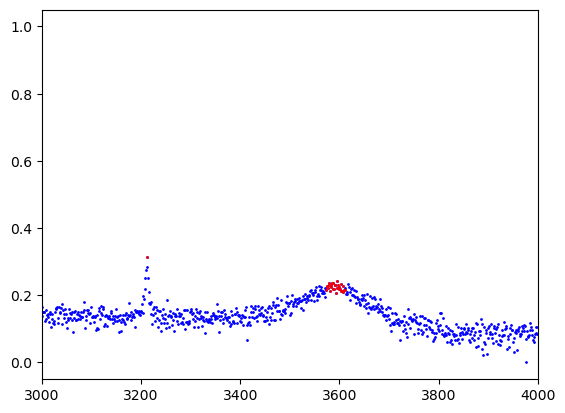

In [56]:
# Plot a sample
i = 1
spectrum = X_train[i]
f = rfftfreq(32768, 1/44100)[0:8192]

labels = y_train[i, :, :]
spread_peak_labels = labels[:, 0]
indices = np.where(spread_peak_labels == 1)[0]
# isolated_peaks = isolated_peaks_train[i]
# indices = np.where(isolated_peaks == 1)[0]
plt.scatter(f, spectrum, color='blue', s=1)
plt.scatter(f[indices], spectrum[indices], color='red', s=1)
plt.xlim(3000, 4000)
plt.show()

In [ ]:
# Verify peak_counting_error
isolated_peaks_val=np.array(
    [[0, 1, 0, 0, 1], 
     [1, 0, 1, 0, 0]]
    )
val_predictions=np.array(
    [[0.81, 0.91, 0.71, 0.31, 0.91],
     [0.81, 0.21, 0.91, 0.96, 0.91]]
    )

peak_counting_error(isolated_peaks_val, val_predictions)

In [ ]:
# Figure out how many bins our peaks are
f = rfftfreq(32768, 1/44100)
# HWFM (in bins) of a peak with a HWHM of 100Hz
bin_width = f[1] - f[0]
print(f"HWFM (in bins) of a peak with a HWHM of 100Hz: {200 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 10Hz: {20 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 3Hz: {6 / bin_width}")

In [ ]:
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss function for (batch_size, N, 3):
#     - Binary cross-entropy for the first output node.
#     - MSE for the second and third output nodes, masked by the first node's true labels.
#     - Each bin in each sample is weighted by f(SNR), where SNR is the 3rd node label.
    
#     Args:
#     y_true: Tensor of true labels, shape (batch_size, N, 3).
#     y_pred: Tensor of predicted values, shape (batch_size, N, 3).
    
#     Returns:
#     A scalar tensor representing the combined loss.
#     """

    # # Mean squared error for the second and third nodes
    # mse_loss_2 = tf.square(y_true[..., 1] - y_pred[..., 1])
    # mse_loss_3 = tf.square(y_true[..., 2] - y_pred[..., 2])
    # mse_loss = mse_loss_2 + mse_loss_3  # Shape (batch_size, N)

    # # Mask the MSE loss where the first node's true label is 0
    # mask = tf.cast(y_true[..., 0] > 0, tf.float32)  # Shape (batch_size, N)
    # masked_mse_loss = mse_loss * mask  # Shape (batch_size, N)
    
    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(SNR), where SNR is the 3rd node label
    # snr = y_true[..., 2]  # SNR is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(snr < 0, tf.ones_like(snr), weight_func(snr))  # If SNR < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func

    # # Apply weights to the masked MSE loss
    # weighted_mse_loss = masked_mse_loss * weights  # Shape (batch_size, N)
    
    # # Apply weights to the BCE loss
    # weighted_bce_loss = bce_loss * weights  # Shape (batch_size, N)

    # # Average weighted MSE, BCE losses across bins (N) for each sample
    # mean_mse_loss_per_sample = tf.reduce_mean(weighted_mse_loss, axis=1)  # Mean over N for shape (batch_size,)
    # mean_bce_loss_per_sample = tf.reduce_mean(weighted_bce_loss, axis=1)

    # # Combine and average across the batch
    # total_loss = tf.reduce_mean(mean_bce_loss_per_sample + mean_mse_loss_per_sample)  # Mean over batch size

    # return total_loss




# class ValidationMetricCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, metric_name="peak_counting_error"):
#         super(ValidationMetricCallback, self).__init__()
#         self.validation_data = validation_data
#         self.metric_name = metric_name

#     def on_epoch_end(self, epoch, logs=None):
#         val_x, (val_y, isolated_peaks_val) = self.validation_data  # Unpack extra labels
#         val_predictions = self.model.predict(val_x, verbose=0)
        
#         # Compute your custom metric (e.g., Mean Absolute Error)
#         val_metric = peak_counting_error(isolated_peaks_val, val_predictions)

#         # Add the validation metric to logs
#         logs[self.metric_name] = val_metric.numpy()

#         print(f"Epoch {epoch + 1}: {self.metric_name} = {val_metric.numpy()}")


# for row_idx in range(y_train.shape[0]):
#     y_peak_labels = y_train[:, :, 0]
#     if tf.reduce_any(y_peak_labels[row_idx] < 0):  # Check if any value in the row is negative
#         print(f"Row {row_idx} contains negative values:")
#         print(y_peak_labels[row_idx])



    # # Check for any negative values or values greater than 1 in y_true
    # has_negative_y_true = tf.reduce_any(y_true < 0)
    # has_greater_one_y_true = tf.reduce_any(y_true > 1)
    
    # # Check for any negative values in y_pred
    # has_negative_y_pred = tf.reduce_any(y_pred < 0)
    
    # # Use tf.debugging.assert_* to enforce conditions during graph execution
    # tf.debugging.assert_equal(
    #     has_negative_y_true, False, message="y_true contains negative values."
    # )
    # tf.debugging.assert_equal(
    #     has_greater_one_y_true, False, message="y_true contains values greater than 1."
    # )
    # tf.debugging.assert_equal(
    #     has_negative_y_pred, False, message="y_pred contains negative values."


    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(prom), where prominence is the 3rd node label
    # prom = y_true[..., 2]  # prom is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(prom < 0, tf.ones_like(prom), weight_func(snr))  # If prom < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func
    


In [32]:
import tensorflow as tf

# Example data
batch_size = 2
bins_per_sample = 4

y_true = tf.constant([[1, 0, 1, 0], [0, 1, 0, 1]], dtype=tf.float32)  # Shape (batch_size, bins_per_sample)
y_pred = tf.constant([[0.9, 0.1, 0.8, 0.3], [0.2, 0.7, 0.3, 0.9]], dtype=tf.float32)  # Shape (batch_size, bins_per_sample)

# Compute element-wise binary cross-entropy
bce_loss = tf.keras.backend.binary_crossentropy(y_true, y_pred)  # Shape (batch_size, bins_per_sample)

# Print the result
tf.print("Element-wise BCE Loss:", bce_loss)


Element-wise BCE Loss: [[0.105360404 0.105360404 0.223143399 0.35667479]
 [0.223143399 0.35667479 0.35667479 0.105360404]]


In [ ]:
# M = 100
# y_train=y_train[0:M, :]
# y_test=y_test[0:M, :]
# y_val=y_val[0:M, :]
# X_train=X_train[0:M, :]
# X_val=X_val[0:M, :]
# X_test=X_test[0:M, :]

# print("TRAIN")
# idx = 1
# print(X_train[idx, :])
# print(y_train[idx, :])
# # Get indices where the value is 1
# indices_where_one = np.where(y_train[idx, :] == 1)[0]

# # Print the indices
# print("Indices where the array is 1:", indices_where_one)

# print("VAL")
# # Print the selected X_val and y_val row
# print("X_val row:", X_val[idx, :])
# print("y_val row:", y_val[idx, :])

# # Get indices where the value is 1 in the validation labels
# indices_where_one_val = np.where(y_val[idx, :] == 1)[0]

# # Print the indices
# print("Indices where the array is 1:", indices_where_one_val)
